# 3D House project

This project consists of plotting an interactive 3D Surface Graph of a house, based on the address provided. The region covered is the region of Flanders (Belgium).

The data are *Lidar* data. The region is divided into 43 rasters. Each raster is in the format **.tif** . This program will select the correct raster after getting from an API the geospatial coordinates corresponding to the address of the house.

## 1. Libraries

In [52]:
import geopandas as gpd
from shapely.geometry import Polygon

import rasterio # Tif files
import os
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
from plotly.graph_objs import *
from rasterio.plot import show
from rasterio.mask import mask

import requests
import json

## 2. Address and coordinates

In [53]:
street_name = input("Street name: ")

Street name:  bolivarplaats


In [54]:
house_number = int(input("House number: "))

House number:  20


In [55]:
post_code = int(input("Post code: "))

Post code:  2000


In [56]:
house_address = f'{street_name} {house_number} {post_code}' # Will be use for the title of the 3D plot later on

In [57]:
# Address request to the basisregisters Vlaanderen API

# HTTP request to the API
address = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch",
                      params={'postcode': post_code, 'straatnaam': street_name, 'huisnummer':house_number})

request = address.json() # Convert http request's response into json format

In [58]:
def get_coordinates(request):
    """
    Function that get the geospatial coordinates and separate the latitude and longitude
    in two different lists (lat, lon).
    """

    request = request['adresMatches'][0]
    
    norm = pd.json_normalize(request)
    norm = norm.loc[0,'adresseerbareObjecten']
    block_url = norm[0].get('detail')
    block_url
    
    # Second request
    address = requests.get(block_url)
    block_details = address.json()
    block_details
    
    building = block_details.get('gebouw')
    url_house = building.get('detail')
    
    # Third request
    house = requests.get(url_house)
    house_details = house.json()


    df = pd.json_normalize(house_details) # Convert the json format into a Pandas DataFrame
    
    house_coordinates = df.loc[0,'geometriePolygoon.polygon.coordinates']
    lat_lon = []

    # Write geometry coordinates to a list
    for list in house_coordinates:
        for sublist in list:
            for coordinates in sublist:
                print(coordinates, end='\n')
                lat_lon.append(coordinates)

    lat = []
    lon = []

    for i, coords in enumerate(lat_lon):
        if i % 2 == 0:
            lat.append(coords)
        else:
            lon.append(coords)

    return lat, lon

In [59]:
lat, lon = get_coordinates(request)

151290.9148921445
210548.07995613664
151286.9813241437
210555.69122014195
151275.0793081373
210549.45320414007
151296.962188147
210506.94818010926
151294.24314814806
210505.55118810758
151292.06017214805
210509.80219611153
151289.05921214074
210508.2212041095
151292.0021881461
210502.4901961051
151291.83918014914
210502.39816410467
151293.72417214513
210498.72418010235
151297.5501561463
210500.6871881038
151296.65518014878
210502.43118810654
151298.74618814886
210503.5042121075
151303.9821561575
210493.3402440995
151298.93262015283
210490.58216409758
151293.97774014622
210487.65742809698
151289.1231481433
210484.5691720955
151254.37127611786
210537.43016412854
151243.07924411446
210530.0021321252
151269.3831161335
210490.0061000958
151266.79514812678
210488.29915609583
151264.21914812922
210492.3021641001
151261.36417212337
210490.46408409625
151264.92014012486
210485.05314009264
151264.75316412747
210484.94312409312
151267.0621561259
210481.43310809135
151270.65415613353
210483.796116

## 3. Creation of the polygon

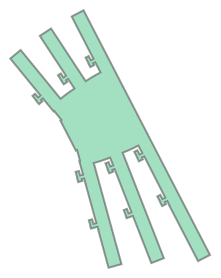

In [60]:
polygon_geometry = Polygon(zip(lat, lon)) # Geometry
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:31370', geometry=[polygon_geometry])

polygon_geometry

## 4. Selection of the raster

All the rasters are located in the local drive and separated in two distincts folders (/DSM and /DTM)

In [61]:
def get_raster_number(coordinates):
    """
    Function that select the correct raster based on the coordinates of the address.
    """
    
    df = pd.read_csv('Utils/rasters_lambert_coordinates.csv') # Load the csv file
    

    # Search for the correct raster
    raster = df[(df['Left'] < coordinates[0]) & (df['Right'] > coordinates[0])
       & ((df['Bottom'] < coordinates[1]) & (df['Top'] > coordinates[1]))]
    
    num_raster = raster['Raster'].item() # Raster number
    
    return num_raster

In [62]:
# Raster number
number = get_raster_number([lat[0],lon[0]])

path_DSM = f"/media/ms/Seagate Expansion Drive/BECODE/Rasters/DSM/DHMVIIDSMRAS1m_k{number}.tif"  
path_DTM = f"/media/ms/Seagate Expansion Drive/BECODE/Rasters/DTM/DHMVIIDTMRAS1m_k{number}.tif"
path_DSM

'/media/ms/Seagate Expansion Drive/BECODE/Rasters/DSM/DHMVIIDSMRAS1m_k15.tif'

## 5. Masking the DSM and DTM

In [63]:
def mask_rasters(DSM_path:str, DTM_path:str) -> str:
    
    # Open DTM and DSM rasters
    raster_DTM = rasterio.open(DTM_path)
    raster_DSM = rasterio.open(DSM_path)


    # Crop of the DTM raster based on the polygon geometry
    masked_DTM, masked_transform_DTM = mask(dataset=raster_DTM, shapes=polygon.geometry, crop=True, pad=True) 


    # Crop of the DSM raster based on the polygon geometry
    masked_DSM, masked_transform_DSM = mask(dataset=raster_DSM, shapes=polygon.geometry, crop=True, pad=True) 

    global profile
    profile = raster_DTM.meta.copy()

    width = masked_DTM.shape[2]
    height = masked_DTM.shape[1]
    profile.update(drivers='GTiff', transform=masked_transform_DTM, height=height, width=width)

    print(profile)

    # Create a new file "masked_DSM.tif" and saving it into the local drive
    with rasterio.open("/home/ms/BeCode/Projects/3D-house-Project/masked_DSM.tif", 'w', **profile) as dst:
        dst.write(masked_DSM) 
    
    # Create a new file "masked_DTM.tif" and saving it into the local drive    
    with rasterio.open("/home/ms/BeCode/Projects/3D-house-Project/masked_DTM.tif", 'w', **profile) as dst:
        dst.write(masked_DTM) # Save the masked DTM

In [64]:
mask_rasters(path_DSM, path_DTM)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 203, 'height': 261, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 151212.0,
       0.0, -1.0, 210557.0), 'drivers': 'GTiff'}


## 6. Creation of the CHM (Canopy Height Model)

In [65]:
def Build_CHM():
    
    m_DTM = rasterio.open('masked_DTM.tif')
    m_DSM = rasterio.open('masked_DSM.tif')

    DSM_array = m_DSM.read(1)
    DTM_array = m_DTM.read(1)
    raster_CHM = DSM_array - DTM_array # Canopy Height Model (CHM) = (DSM - DTM)
    show(raster_CHM)

    print(profile)

     # Create a new file "CHM.tif" and save it into the local drive
    with rasterio.open("/home/ms/BeCode/Projects/3D-house-Project/CHM.tif", 'w', **profile) as dst:
        dst.write(raster_CHM, 1)

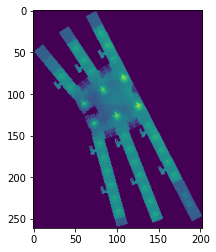

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 203, 'height': 261, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 151212.0,
       0.0, -1.0, 210557.0), 'drivers': 'GTiff'}


In [66]:
Build_CHM()

## 7. 3D Plot

The library used is **plotly**. The 3D Surface plot opens in the browser in a new tab.

In [67]:
def Plot_3d():
    CHM = rasterio.open('CHM.tif')
    CHM_array = CHM.read(1) # Convert the raster into a Numpy array

    #Plot
    fig = go.Figure(data=[go.Surface(z=CHM_array)]) # Create the figure from the CHM array
    fig.update_layout(title=f'3D Plot - {house_address}', title_x=0.5,
                    scene = dict(
                    xaxis_title='Distance (m)',
                    yaxis_title='Distance (m)',
                    zaxis_title='Height'),
                    font=dict(
                    family="Courier New, monospace",
                    size=18,
                    color="RebeccaPurple"))
    fig.update_scenes(yaxis_autorange="reversed")

    plot(fig) # Plot the house in new tab

In [68]:
Plot_3d()